In [1]:
import numpy as np
import os
import skimage.io as skio
import matplotlib.pyplot as plt
import pandas as pd
import deepforest as df
import geopandas as gpd
import rasterio


indir = "E:/MUSA 650 Final Project/plantations/sample"

# set the filepath
tifs_path = os.path.join(indir, "tifs")

In [2]:
import glob
import os
import urllib
import numpy as np

import intake
import matplotlib.pyplot as plt
import xmltodict
import cv2

import tempfile

import torch

In [3]:
# create an empty list to store the tif files
tif_list = []

# loop through all tif files in the folder and append to the list
for file in os.listdir(tifs_path):
    if file.endswith(".tif"):
        tif_file = os.path.join(tifs_path, file)
        tif_list.append(skio.imread(tif_file))

# convert the list to a numpy array
tifs = np.array(tif_list)

We noticed here that some of the TIFs seem to be importing with an extra channel in addition to RGB. We weren't sure why, so we printed out the images.

In [4]:
# Loop through tif_patches_array and print the shape of each array
for i, tifs in enumerate(tifs):
    print(f"TIF {i}: shape = {tifs.shape}")

TIF 0: shape = (5100, 6600, 3)


It appears that the extra channels are just junk--empty values--so we can drop them.

In [5]:
def visualize_channels(image_path):
    img = skio.imread(image_path)
    height, width, channels = img.shape

    if channels != 4:
        print(f"Image {image_path} does not have 4 channels")
        return

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    channel_names = ['Red', 'Green', 'Blue', 'Extra']

    for i in range(4):
        axs[i].imshow(img[:, :, i], cmap='gray')
        axs[i].set_title(f'{channel_names[i]} Channel')
        axs[i].axis('off')

    plt.show()

tifs_path = "E:/MUSA 650 Final Project/plantations/sample/tifs/"

for file in os.listdir(tifs_path):
    if file.endswith(".tif"):
        tif_file = os.path.join(tifs_path, file)
        visualize_channels(tif_file)

Image E:/MUSA 650 Final Project/plantations/sample/tifs/site2.tif does not have 4 channels


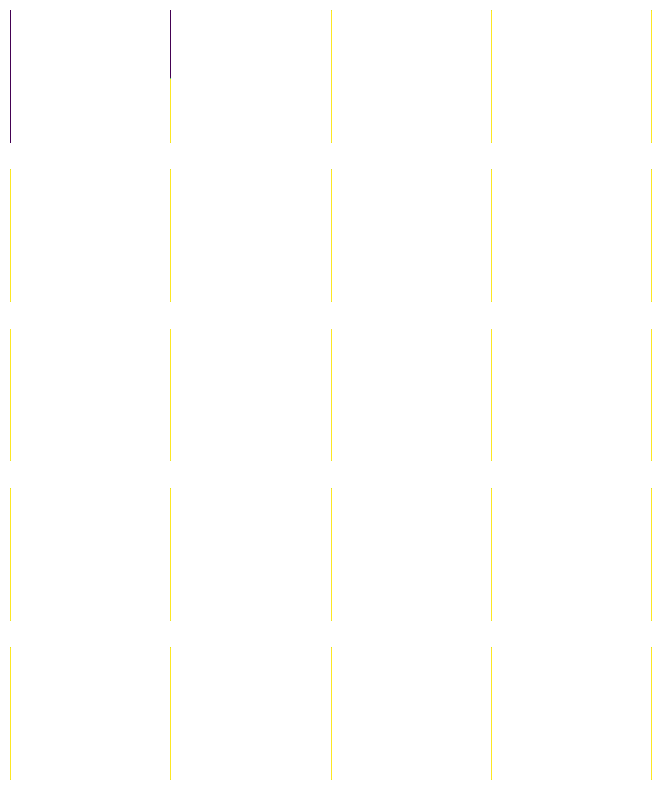

In [6]:
from matplotlib import gridspec

# Create a 5x5 grid
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(5, 5)

# Iterate through each tif file and place it in the grid
for i in range(5):
    for j in range(5):
        if i*5 + j < len(tifs):
            tif = tifs[i*5 + j]
            ax = fig.add_subplot(gs[i,j])
            ax.imshow(tif)
            ax.set_axis_off()

plt.show()

In [7]:
tifs[1].shape

(6600, 3)

In [8]:
def extract_and_pad_patches(image, patch_size=(256, 256, 3), stride=256):
    patches = []
    height, width, channels = image.shape

    # If the image has more than 3 channels, extract only the first 3 (assumes RGB)
    if channels > 3:
        image = image[:, :, :3]

    for y in range(0, height, stride):
        for x in range(0, width, stride):
            patch = image[y:y+patch_size[0], x:x+patch_size[1], :]

            # Check if padding is needed
            if patch.shape[0] < patch_size[0] or patch.shape[1] < patch_size[1]:
                pad_height = patch_size[0] - patch.shape[0]
                pad_width = patch_size[1] - patch.shape[1]

                # Pad the patch with zeros (black)
                patch = np.pad(
                    patch,
                    pad_width=((0, pad_height), (0, pad_width), (0, 0)),
                    mode='constant',
                    constant_values=0
                )

            patches.append(patch)

    return patches

In [9]:
# create an empty list to store the tif files
tif_patches_list = []

# loop through all tif files in the folder and append to the list
for file in os.listdir(tifs_path):
    if file.endswith(".tif"):
        tif_file = os.path.join(tifs_path, file)
        img = skio.imread(tif_file)

        # Extract and pad patches from the image
        patches = extract_and_pad_patches(img)
        tif_patches_list.append(patches)

# convert each list of patches to a numpy array
tif_patches_array = [np.array(patches) for patches in tif_patches_list]

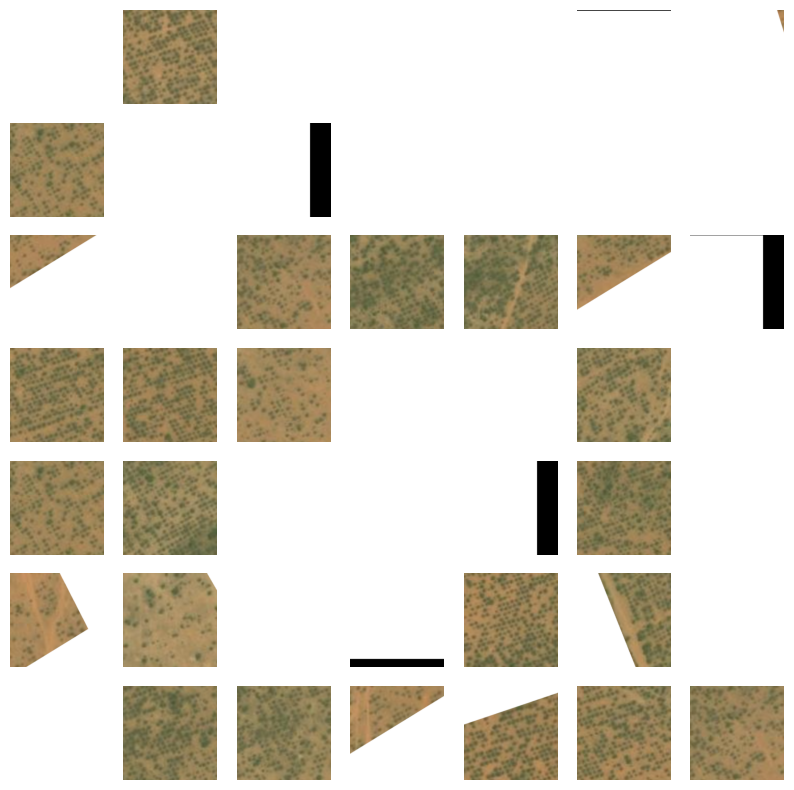

In [10]:
# print 49 random images from tif_patches_array in a 7x7 grid, but with no borders or axes
fig, axes = plt.subplots(7, 7, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(tif_patches_array[0][np.random.randint(0, len(tif_patches_array[0]))])
    ax.axis('off')
plt.show()

In [11]:
# Loop through tif_patches_array and print the shape of each array
for i, patches in enumerate(tif_patches_array):
    print(f"Array {i}: shape = {patches.shape}")

Array 0: shape = (520, 256, 256, 3)


In [12]:
# Concatenate all of the images in tif_patches_array into a single array
tif_patches_full = np.concatenate(tif_patches_array, axis=0)

In [13]:
tif_patches_full.shape

(520, 256, 256, 3)

Great, now we can augment our images to give ourselves more data to train on. We'll simply double it.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# define the number of samples to generate
n_samples = int(tif_patches_full.shape[0])

In [15]:
print(n_samples)

520


In [16]:
y = None
augmented_data = datagen.flow(tif_patches_full, y, batch_size=n_samples)

# Access and visualize a batch of augmented images
batch_X = next(augmented_data)

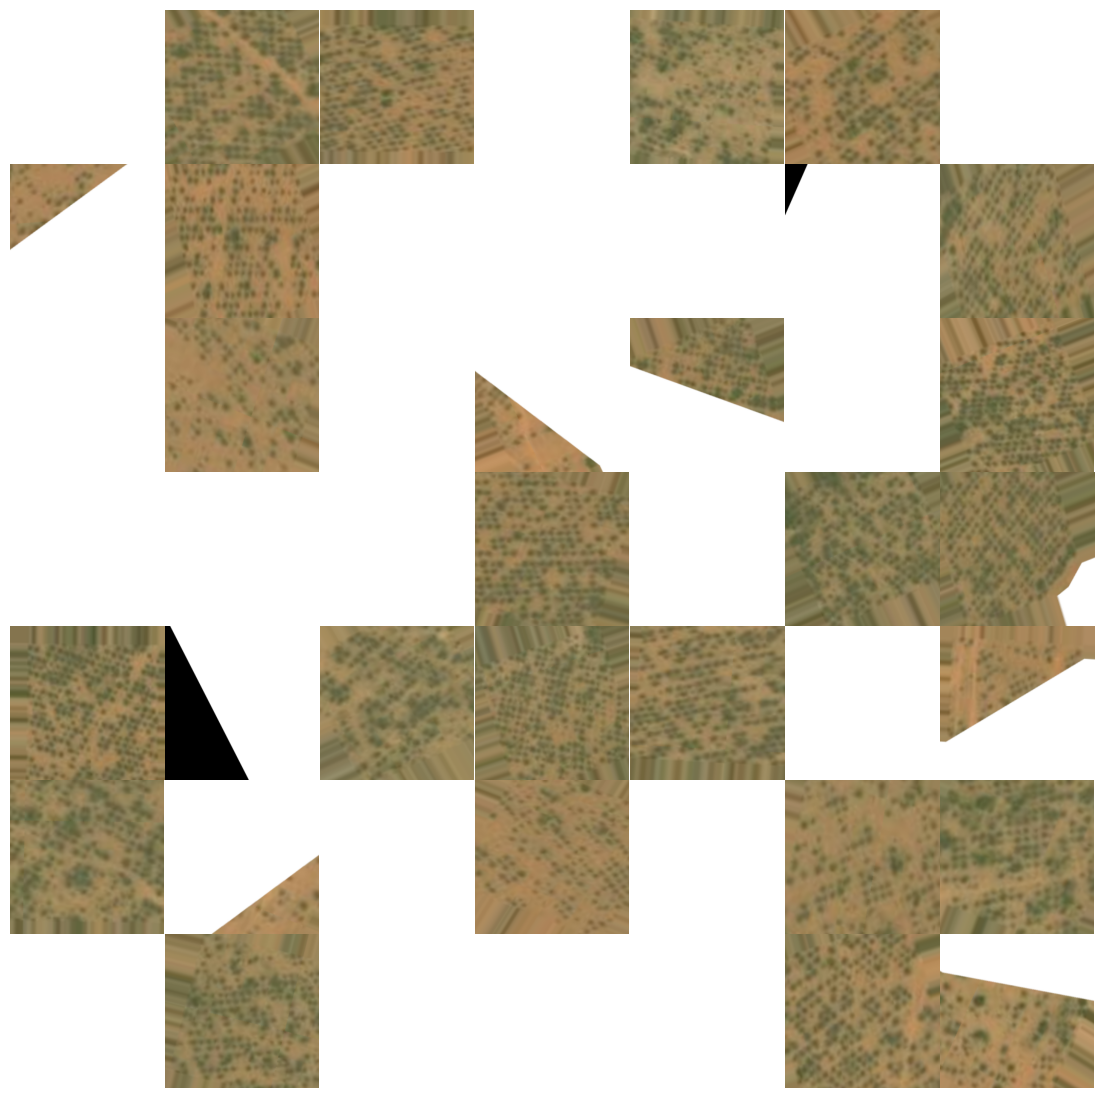

In [17]:
import matplotlib.pyplot as plt

# Set up the grid of subplots
fig, axes = plt.subplots(7, 7, figsize=(14, 14))

# Remove the space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the images and display them in the grid
for i in range(7):
    for j in range(7):
        img_index = i * 7 + j
        if img_index < len(batch_X):
            axes[i, j].imshow(batch_X[img_index].astype('uint8'))

        # Remove axis ticks and labels
        axes[i, j].axis('off')

# Show the grid of images
plt.show()

In [18]:
# Concatenate batch_X with tif_patches_full
tif_patches_full_augmented = np.concatenate((tif_patches_full, batch_X), axis=0)

# Check the new shape of tif_patches_full_augmented
print(f"New shape of tif_patches_full_augmented: {tif_patches_full_augmented.shape}")

New shape of tif_patches_full_augmented: (1040, 256, 256, 3)


In [19]:
import tensorflow as tf

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [20]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
# Deep Forest
from deepforest import main
from deepforest import get_data
import os
import matplotlib.pyplot as plt

model = main.deepforest()
model.use_release()

img = model.predict_image(path="E:/MUSA 650 Final Project/plantations/sample/tifs/site2.tif", return_plot=True)


Reading config file: c:\Users\Tristan\miniconda\envs\remote-sensing\lib\site-packages\deepforest\data\deepforest_config.yml
No validation file provided. Turning off validation loop


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [24]:
image_path = get_data("E:/MUSA 650 Final Project/plantations/sample/tifs/site2.tif")

In [47]:
boxes = model.predict_image(path=image_path, return_plot = False)

In [48]:
#print boxes
print(boxes)

None


In [26]:
import torch
import torchvision

print(torch.__version__) #https://github.com/pytorch/vision#installation
print(torchvision.__version__)

2.0.0
0.15.1+cpu


In [79]:
predicted_raster = model.predict_tile(image_path, return_plot = True, patch_size=100,patch_overlap=0.1)


c:\Users\Tristan\miniconda\envs\remote-sensing\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0:  24%|██▎       | 1001/4218 [35:21<1:53:37,  2.12s/it]

In [ ]:
import numpy as np
from PIL import Image

#convert numpy array to PIL image
img = Image.fromarray(predicted_raster)


In [ ]:
img.save('E:/MUSA 650 Final Project/plantations/sample/tifs/site2_DFpredicted_100patchsize.tif')


In [ ]:
# function to plot images
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [ ]:

#plot predicted_raster


In [29]:
#print type of predicted_raster
print(type(predicted_raster))

<class 'numpy.ndarray'>


In [43]:
import numpy as np

print(type(predicted_raster))
print(isinstance(predicted_raster, np.ndarray))

<class 'rasterio.io.DatasetWriter'>
False


In [42]:
import rasterio

# Specify the output file location
output_file = 'E:/MUSA 650 Final Project/plantations/sample/tifs/predicted_raster.tif'

# Get the shape of the array
height, width = predicted_raster.shape

# Define the metadata for the output file
meta = {
    'driver': 'GTiff',
    'count': 1,
    'height': height,
    'width': width,
    'dtype': predicted_raster.dtype,
    'transform': rasterio.transform.from_origin(0, 0, 1, 1), # you may need to update this based on your data
    'crs': rasterio.crs.CRS.from_epsg(4326), # you may need to update this based on your data
}

# Write the array to the output file
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(predicted_raster, 1)




AttributeError: 'DatasetWriter' object has no attribute 'dtype'

Load DeepForest pretrained model

In [55]:
import glob
import os
import urllib
import numpy as np

import intake
import matplotlib.pyplot as plt
import xmltodict
import cv2

import tempfile

import torch


# load in tif image from E:/MUSA 650 Final Project/plantations/sample/tifs/site2.tif
image_path = "E:/MUSA 650 Final Project/plantations/sample/tifs/site2.tif"
#use image_path to load in the rgb image
rgb = cv2.imread(image_path)

image = rgb

In [58]:
#use intake to load in image
image = intake.open_imageio('E:/MUSA 650 Final Project/plantations/sample/tifs/site2.tif')

AttributeError: open_imageio

In [56]:
# load deep forest model
model = main.deepforest()
model.use_release()
model.current_device = torch.device("cpu")

Reading config file: c:\Users\Tristan\miniconda\envs\remote-sensing\lib\site-packages\deepforest\data\deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [57]:
pred_boxes = model.predict_image(image=image.values)
print(pred_boxes.head(5))

AttributeError: 'numpy.ndarray' object has no attribute 'values'